In [2]:
# Author : Shamsulhaq Basir
# email  : shamsbasir@gmail.com

In [14]:
import time
import os
import torch
import torch.nn as nn
import numpy as np
from torch.optim import LBFGS


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec

torch.set_default_dtype(torch.float64)


In [2]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net =nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 

    def forward(self, x):
        out = self.net(x)
        return out 

In [3]:
class Network(torch.nn.Module):
    def __init__(self,in_N,m,H_Layer,out_N,**kwargs):
        super(Network,self).__init__()
        self.mu  = kwargs["mean"]
        self.std = kwargs["stdev"]
            
        layers = []
        layers.append(ConventBlock(in_N,m))
        for i in range(0,H_Layer-1):
            layers.append(ConventBlock(m,m))
         # output layer
        layers.append(nn.Linear(m,out_N))
        # total layers
        self.net = nn.Sequential(*layers)

        
    def forward(self,x,y):
        data = torch.cat((x,y),dim=1);
        # normalize the input
        data = (data - self.mu)/self.std
        out  = self.net(data)
        return out
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [4]:
# ----------------------------------------------
#  Defining the rhs : u_xx + u_yy + u = f(x,y)
# ----------------------------------------------
omega = torch.tensor([1.0, 4.0])
def u_exact(x,y,omega):
    return torch.sin(omega[0]*np.pi*x)*torch.sin(omega[1]*np.pi*y) 

def u_xx(x,y,omega):
    return -(omega[0]*np.pi).pow(2) * u_exact(x,y,omega)

def u_yy(x,y,omega):
    return -(omega[1]*np.pi).pow(2) * u_exact(x,y,omega)


def source_function(x,y,omega):
    result = u_xx(x,y,omega) + u_yy(x,y,omega) + u_exact(x,y,omega)
    return result


In [5]:
def fetch_interior_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(N_data,dtype=torch.float64)*(domain[1] - domain[0]) + domain[0]
    x       = data[:,0][:,None]
    y       = data[:,1][:,None]
    return x,y

In [6]:
def fetch_boundary_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    dim      = domain.shape[0]
    N_data   = N_data//dim**2
    
    x,y      =  fetch_interior_points(domain,N_data)
    
    E_bc = torch.cat(( torch.ones_like(x),     y), dim = 1)
    W_bc = torch.cat(( torch.full_like(x,x_min),y), dim = 1)

    N_bc = torch.cat((x, torch.ones_like(y)     ), dim = 1)   
    S_bc = torch.cat((x, torch.full_like(y,y_min)), dim = 1)
    
    data   = torch.cat((N_bc, S_bc, E_bc, W_bc), dim = 0)
    
    
    x      = data[:,0][:,None]
    y      = data[:,1][:,None]
    return x,y

In [7]:
def physics_loss(model,x,y,omega):
    u       = model(x,y)
    u_x,u_y = torch.autograd.grad(u.sum(),(x,y),create_graph=True)
    u_xx    = torch.autograd.grad(u_x.sum(),x,create_graph=True)[0]
    u_yy    = torch.autograd.grad(u_y.sum(),y,create_graph=True)[0]
    lhs     = u_xx + u_yy + u
    rhs     = source_function(x,y,omega)
    
    loss = (lhs - rhs).pow(2)
    return loss

In [8]:
def boundary_loss(model,x,y,omega):
    u       = model(x,y)
    ue      = u_exact(x,y,omega) 
    loss    = (u - ue).pow(2)
    return loss

In [9]:
# neural network model
kwargs ={"mean":0.0, "stdev":0.5772}  
domain   = np.array([[-1.,-1.],[1.,1.]])
model = Network(in_N=2,m=30,H_Layer=3,out_N=1,**kwargs)
print(model)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [10]:
def evaluate(model,domain):
    model.eval()
    xstar = np.linspace(domain[0][0],domain[1][0],64)
    ystar = np.linspace(domain[0][1],domain[1][1],64)

    x_star,y_star = np.meshgrid(xstar,ystar)
    x_test = torch.from_numpy(x_star.flatten()[:,None])
    y_test = torch.from_numpy(y_star.flatten()[:,None])

    u_star = u_exact(x_test,y_test,omega)   
    u_pred = model(x_test,y_test)
    
    l2   = np.linalg.norm(u_star- u_pred.detach(), 2)/np.linalg.norm(u_star, 2)
    linf = max(abs(u_star- u_pred.detach().numpy()))
    return l2,linf.item()

In [11]:
epochs          = 5000
disp            = 500
print_to_consol = True

# reset the model
model.apply(init_weights)

# update the optimizer
optimizer = LBFGS(model.parameters(),line_search_fn="strong_wolfe")

# initialize penalty parameter
mu           = torch.tensor(1.0)

# maximum penalty value for safeguarding
mu_max      = torch.tensor(1e4)

# l2 norm of constraints |C|_2
eta          = torch.tensor(0.0)

# penalty tolerance
epsilon      = torch.tensor(1e-8)

# number of collocation points in the domain
N_data     = 512

x_dm,y_dm  = fetch_interior_points(domain,N_data)
x_dm       = x_dm.requires_grad_(True)
y_dm       = y_dm.requires_grad_(True)

# number of boundary points
N_data     = 256

# Generating Data  
x_bc,y_bc  = fetch_boundary_points(domain,N_data)

# lagrange multiplier for boundary conditions 
lambda_bc  = torch.zeros_like(x_bc)

# starting to train neural network model
for epoch in range(1,epochs+1):

    def closure():
        if torch.is_grad_enabled():
            model.train()
            optimizer.zero_grad()
        pde_loss       = physics_loss(model,x_dm,y_dm,omega).sum()
        bc_constraints = boundary_loss(model,x_bc,y_bc,omega)
        bc_loss        = (lambda_bc * bc_constraints).sum()
        penalty        = bc_constraints.pow(2).sum()

        loss      = pde_loss +  bc_loss + 0.5 * mu * penalty
        if loss.requires_grad:
            loss.backward()
        return loss

    def _closure():
        model.eval()
        pde_loss         = physics_loss(model,x_dm,y_dm,omega)
        bc_constraints   = boundary_loss(model,x_bc,y_bc,omega)
        penalty          = bc_constraints.pow(2).sum()
        return pde_loss,bc_constraints,penalty

    optimizer.step(closure)
    pde_loss,bc_constraints,penalty = _closure()

    with torch.no_grad():
        if (torch.sqrt(penalty) >= 0.25*eta) and (torch.sqrt(penalty) > epsilon):
            mu         = min(mu*2.0, mu_max)
            lambda_bc += mu * bc_constraints
        eta  = torch.sqrt(penalty)   
        # print average pde loss and the constraint norm |pi|_2 
        if epoch %disp == 0 and print_to_consol:
            print(f"epoch: {epoch : 5d}, avg pde loss:{pde_loss.mean():2.3e}, eta : {eta:2.3e}")

# checkpointing the model 
torch.save(model.state_dict(),f"helmholtz.pt")
l2,linf = evaluate(model,domain)
print(f"relative l2 error :{l2:2.3e}, linf error : {linf :2.3e}")

epoch:   500, avg pde loss:4.851e-03, eta : 3.543e-05
epoch:  1000, avg pde loss:1.700e-03, eta : 1.384e-05
epoch:  1500, avg pde loss:8.353e-04, eta : 5.503e-06
epoch:  2000, avg pde loss:4.667e-04, eta : 4.450e-06
epoch:  2500, avg pde loss:3.136e-04, eta : 2.454e-06
epoch:  3000, avg pde loss:2.303e-04, eta : 1.730e-06
epoch:  3500, avg pde loss:1.801e-04, eta : 1.058e-06
epoch:  4000, avg pde loss:1.412e-04, eta : 1.084e-06
epoch:  4500, avg pde loss:1.172e-04, eta : 7.622e-07
epoch:  5000, avg pde loss:9.840e-05, eta : 5.955e-07
relative l2 error :1.702e-04, linf error : 6.615e-04


In [12]:
model.eval()
xstar = np.linspace(domain[0][0],domain[1][0],64)
ystar = np.linspace(domain[0][1],domain[1][1],64)

x_star,y_star = np.meshgrid(xstar,ystar)
x_test = torch.from_numpy(x_star.flatten()[:,None])
y_test = torch.from_numpy(y_star.flatten()[:,None])


u_star = u_exact(x_test,y_test,omega)   
u_pred  = model(x_test,y_test)

l2,linf = evaluate(model,domain)
print(f"relative l2 error :{l2:2.3e}, linf error : {linf :2.3e}")

relative l2 error :1.702e-04, linf error : 6.615e-04


In [15]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((0, 0))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels
    'axes.titlesize': 16,
    'font.size': 16, 
    'legend.fontsize': 16, 
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [20, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)

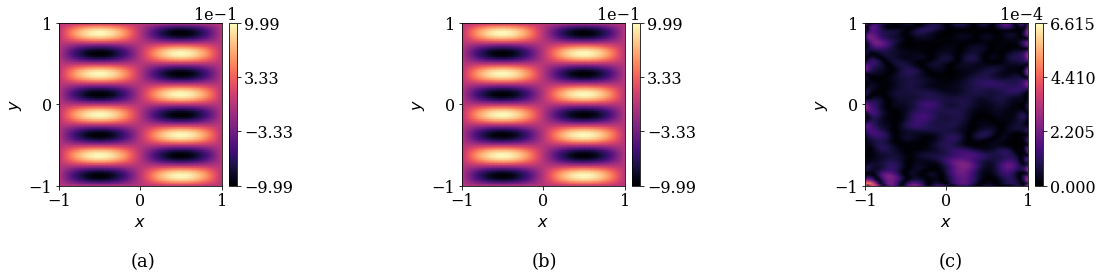

In [16]:
# ------------
# 2D figures
# --------------
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = cmap_list[4]
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.3)

points      = np.concatenate((x_star.flatten()[:,None],y_star.flatten()[:,None]),axis=1)
u_pred_plot = griddata(points, u_pred.detach().flatten(), (x_star,y_star), method='cubic')
u_star_plot = griddata(points, u_star.flatten(), (x_star,y_star), method='cubic')


save = True
#################################### Predicted Solution #####################################
ax = plt.subplot(gs[0,0])
min_val = np.min(u_star_plot)
max_val = np.amax(u_star_plot)
img = ax.pcolormesh(x_star,y_star,u_pred_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
# ax.set_title('$\hat{u}(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.axis('square')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((-1, -1))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])

    
# #################################### Exact Solution #########################################
ax = plt.subplot(gs[0,1])
img = ax.pcolormesh(x_star,y_star,u_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
# ax.set_title('$u(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((-1, -1))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


# #################################### Absolute Error #########################################
ax = plt.subplot(gs[0,2])
img = ax.pcolormesh(x_star,y_star,np.abs(u_star_plot - u_pred_plot), cmap = cmap,shading='gouraud')
# ax.set_title('$|u - \hat{u}|$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

min_val = np.amin(np.abs(u_star_plot - u_pred_plot))
max_val = np.amax(np.abs(u_star_plot - u_pred_plot))
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((0, 0))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


filename="pecann_helmholtz"
plt.figtext(0.229, -0.25,'(a)' ,wrap=True, horizontalalignment='center', fontsize=18)
plt.figtext(0.508, -0.25,'(b)', wrap=True, horizontalalignment='center', fontsize=18)
plt.figtext(0.790, -0.25,'(c)', wrap=True, horizontalalignment='center', fontsize=18)
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.2)